In [1]:
from flax import nnx
from flax import linen
import jax
import jax.numpy as jnp
import torch
import os
from pytorch_model import UNET2D
from jax_unet import unet

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import utils.utilities as ut
from models import time_integration
from torch.utils.data import DataLoader
from dataset.dataset_nemo import preprocess_data
from models import networks as net

from jax import ops

import logging
from src.nnUtils import autoregressive
import io
import re
log = logging.getLogger(__name__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {DEVICE}")


Running on: cpu


In [2]:
# Initialize model parameters
num_layers = 5
in_channels = [3, 2]  # [dynamics_channels, statics_channels]
out_channels = 3
features = [16, 32, 64, 128, 256]
kernel_size = (3, 3)
stride = 1
padding = 1
# Create model
model = unet(
    num_layers=num_layers,
    in_channels=in_channels,
    out_channels=out_channels,
    features=features,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding,
)

# # Create sample input data
# batch_size = 1
# height, width = 100, 100
# x = jnp.ones((1, height, width, in_channels[0]))  # Dynamic input
# H = jnp.ones((1, height, width, 1))  # Static terrain
# mask = jnp.ones((1, height, width, 1))  # Binary mask

# # Pass data through model
# output = model(x, H=H, mask=mask)
# print(f"Jax model total parameters: {model.total_params()}")
# model.summary()
model.load_torch_weights()

# print(f"Input shape: {x.shape}")
# print(f"Output shape: {output.shape}")
# print(f"Expected output channels: {out_channels}")

print(model)

DEVICE on Loading model:  cpu
+++++++++++++++++++ LOADING trained model ++++++++++++++++++++++++++
=== PyTorch Model Parameter Counts ===
dynamics.weight: 216 parameters
dynamics.bias: 8 parameters
statics.weight: 144 parameters
statics.bias: 8 parameters
encoder.0.conv.0.weight: 2,304 parameters
encoder.0.conv.0.bias: 16 parameters
encoder.0.conv.1.weight: 16 parameters
encoder.0.conv.1.bias: 16 parameters
encoder.0.conv.3.weight: 2,304 parameters
encoder.0.conv.3.bias: 16 parameters
encoder.1.conv.0.weight: 4,608 parameters
encoder.1.conv.0.bias: 32 parameters
encoder.1.conv.1.weight: 32 parameters
encoder.1.conv.1.bias: 32 parameters
encoder.1.conv.3.weight: 9,216 parameters
encoder.1.conv.3.bias: 32 parameters
encoder.2.conv.0.weight: 18,432 parameters
encoder.2.conv.0.bias: 64 parameters
encoder.2.conv.1.weight: 64 parameters
encoder.2.conv.1.bias: 64 parameters
encoder.2.conv.3.weight: 36,864 parameters
encoder.2.conv.3.bias: 64 parameters
encoder.3.conv.0.weight: 73,728 paramete

In [3]:

CONDI_NET           = False
# NETWORK             = "UNETSWEv4"
# FORWARD_MODEL       = "ForwardEulerConstraintBC"
NETWORK             = "UNET2D"
FORWARD_MODEL       = "ForwardEuler"
DT                  = 300
# EXP_NAME          = "unet_closedbc_swe_scaleddata_exp2"
EXP_NAME            = "unet_closedbc_swe_std_exp6"
TESTCASE            = "swe"
NORMALIZE           = True
# NORMALIZE_TYPE      = "scale"
NORMALIZE_TYPE      = "std"
# PATH_TO_FILE      = "/work/gg0028/g260225/dev/diff-ocean-nemo/data/swe/smalldataset_dt300.npz"
wkdir               = "/home/minh/coding/dev/machinelearning/diff-ocean-nemo"
PATH_TO_FILE        = f"{wkdir}/data/swe/swe_d15_1data_100x100_dt300.npz"
SAVE_FWD_DIR        = f"{wkdir}/saved/forward"
FWD_EXP_DIR         = f"{SAVE_FWD_DIR}/{EXP_NAME}"
pathfile            = f"{FWD_EXP_DIR}/model.pth.tar"
folder_saving = FWD_EXP_DIR
CONSTRAINT_BC       = True


network_params = {
    'name': 'UNET2D',
    'condi_net': False,
    'in_channels': [3, 2],
    'out_channels': [3],
    'features': [16, 32, 64, 128, 256],
    'kernel_size': 3,
    'stride': 1,
    'padding': 1,
    'norm_type': 'GroupNorm',
    'activation': 'SiLU',
    'num_layers': 5,
}

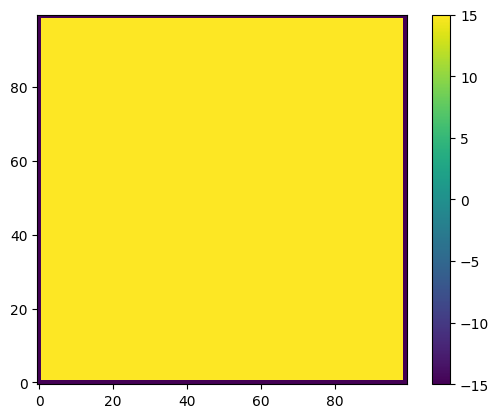

ssh.shape =  (1, 301, 100, 100)


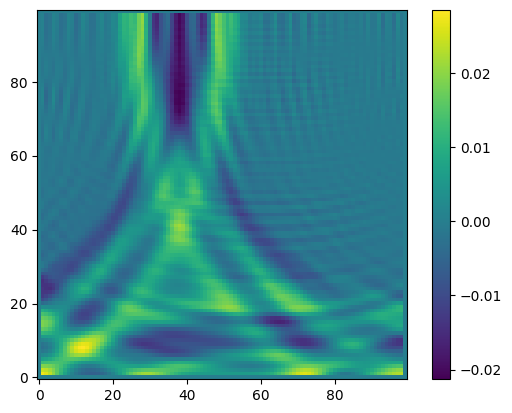

x0_mean:  5.4975302e-05
x0_std:  1.0005038
x1_mean:  -0.00013156311
x1_std:  1.0003442
x2_mean:  -0.0009699822
x2_std:  1.0001193
(1, 301, 3, 100, 100)
(300, 3, 100, 100)


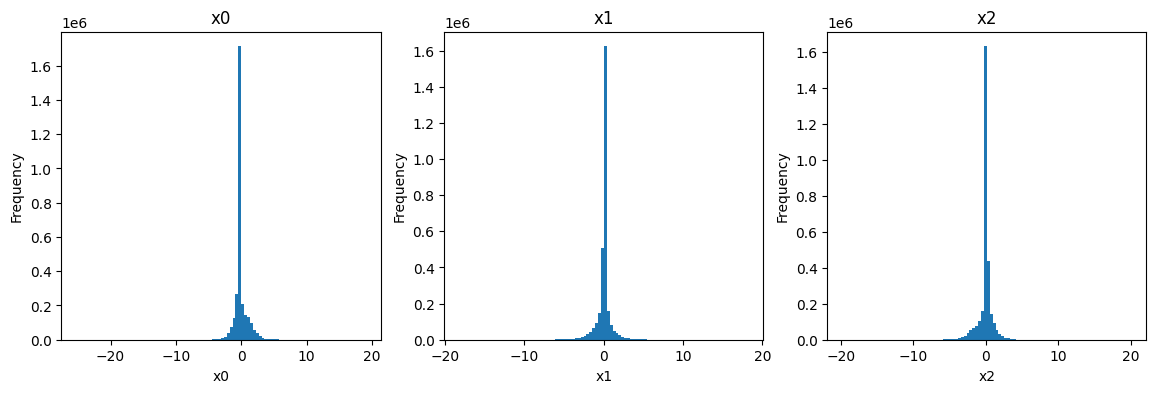

In [4]:
ocean_ds, ssh, params = preprocess_data(np.load(PATH_TO_FILE), TESTCASE, CONDI_NET, True, NORMALIZE_TYPE)
ut.plot_distribution_histogram(ocean_ds.X_input, 3)
print(ocean_ds.data.shape)
print(ocean_ds.X_input.shape)

In [5]:
sshBC = -ocean_ds.normalize['ssh']['mean'] / ocean_ds.normalize['ssh']['std']
uBC = -ocean_ds.normalize['u']['mean'] / ocean_ds.normalize['u']['std']
vBC = -ocean_ds.normalize['v']['mean'] / ocean_ds.normalize['v']['std']
print(sshBC, uBC, vBC)


-0.13089944 0.039507672 0.14766209


In [6]:
class Emulator():
    def __init__(self, model, sshBC, uBC, vBC):
        self.model = model
        self.sshBC = sshBC
        self.uBC = uBC
        self.vBC = vBC
    
    # Define the forward pass
    def forward(self, x, H, mask):
        dx_dt = self.model(x, H=H, mask=mask)
        dT = 300
        x_next = x + dx_dt * dT
        # apply boundary conditions: assign 0.12 values of x_next the the boundary pixels for the 1st channel
        # apply boundary conditions: assign 0.12 values of x_next to the boundary pixels for the 1st channel
        x_next = x_next.at[:, 0, :, 0].set(self.sshBC)
        x_next = x_next.at[:, -1, :, 0].set(self.sshBC)
        x_next = x_next.at[:, :, 0, 0].set(self.sshBC)
        x_next = x_next.at[:, :, -1, 0].set(self.sshBC)
        # apply boundary conditions: assign 0.24 values of x_next the the boundary pixels for the 2nd channel
        x_next = x_next.at[:, 0, :, 1].set(self.uBC)
        x_next = x_next.at[:, -1, :, 1].set(self.uBC)
        x_next = x_next.at[:, :, 0, 1].set(self.uBC)
        x_next = x_next.at[:, :, -1, 1].set(self.uBC)
        # apply boundary conditions: assign 0.36 values of x_next the the boundary pixels for the 2nd channel
        x_next = x_next.at[:, 0, :, 2].set(self.vBC)
        x_next = x_next.at[:, -1, :, 2].set(self.vBC)
        x_next = x_next.at[:, :, 0, 2].set(self.vBC)
        x_next = x_next.at[:, :, -1, 2].set(self.vBC)

        return x_next
    
       

(1, 1, 100, 100)
(1, 3, 100, 100)


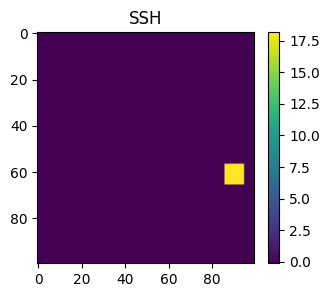

In [7]:
# simulation swe with autoregressive model for 10 time steps
# create H0 with jax array
H0 = jnp.array(ocean_ds.H[0:1])
mask0 = jnp.array(ocean_ds.maskBC[0:1])
x0 = jnp.array(ocean_ds.X_input[0:1])
params0 = jnp.array(params[0:1]) if params is not None else None

print(H0.shape)
print(x0.shape)
# plot x0 initial condition
plt.figure(figsize=(3.5, 3))
plt.subplot(1, 1, 1)
plt.imshow(x0[0, 0, :, :], aspect='auto')
plt.colorbar()
plt.title("SSH")
time_steps = 300
# emulator_sims = autoregressive(forward_model, x0, params0, H0, mask0, time_steps, folder_saving)
# emulator_sims = autoregressive(emulator, x0, params0, H0, mask0, time_steps, folder_saving)

In [8]:
emulator = Emulator(model, sshBC=sshBC, uBC=uBC, vBC=vBC)


In [9]:
type(x0)

jaxlib.xla_extension.ArrayImpl

In [10]:
# move the 2nd dimension to the last dimension
x0 = np.moveaxis(x0, 1, -1)
H0 = np.moveaxis(H0, 1, -1)
mask0 = np.moveaxis(mask0, 1, -1)
print(x0.shape)
print(H0.shape)
print(mask0.shape)


(1, 100, 100, 3)
(1, 100, 100, 1)
(1, 100, 100, 1)


In [11]:
type(x0)

jaxlib.xla_extension.ArrayImpl

In [36]:
# autogressive simulation
from typing import Union, List
def run_simulation(state, emulator, H_bathy, mask, further_step: Union[int, List[int]] = 1):
    assert isinstance(further_step, (int, list)), "further_step must be either an integer or a list"
    further_step = [further_step] if isinstance(further_step, int) else further_step
    # emulator.model.eval()
    states = []      
    # for step in further_step:
    for i, step in enumerate(further_step):
        if i == 0 and step == 0:
            states.append(state)
            continue
        # Simplify the loop by directly using the last state if available
        if i == 0 and step > 0:
            for _ in range(step):
                # state = emulator.forward(state, params=params, H=H_bathy, mask=mask)
                state = emulator.forward(state, H_bathy, mask)
                state = state.reshape(1, 100, 100, 3)
            states.append(state)
        elif i > 0:
            for j, val in enumerate(range(further_step[i]-further_step[i-1])):
                # state = emulator.forward(state, params=params, H=H_bathy, mask=mask)
                state = emulator.forward(state, H_bathy, mask)
                state = state.reshape(1, 100, 100, 3)
            states.append(state)
    len(states)
    return jnp.concatenate(states, axis=0)

In [38]:
# run simulation for 10 time steps
further_step = 300
# create a list from 0 to 300
further_step = list(range(further_step))
emulator_sims = run_simulation(x0, emulator, H0, mask0, further_step)
print(emulator_sims.shape)

(300, 100, 100, 3)


## Plot comparison between simulator and differentiable emulator

(300, 100, 100, 3)


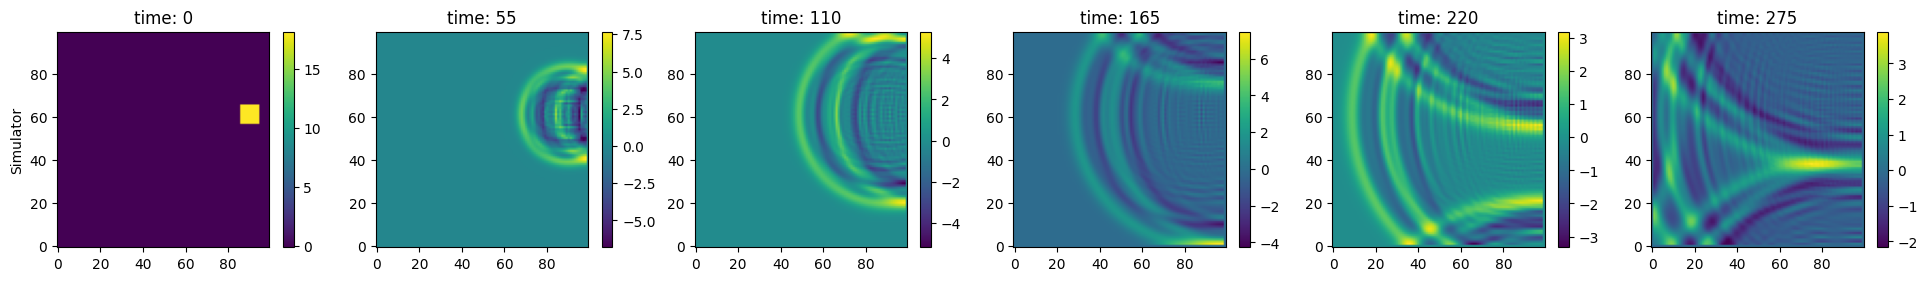

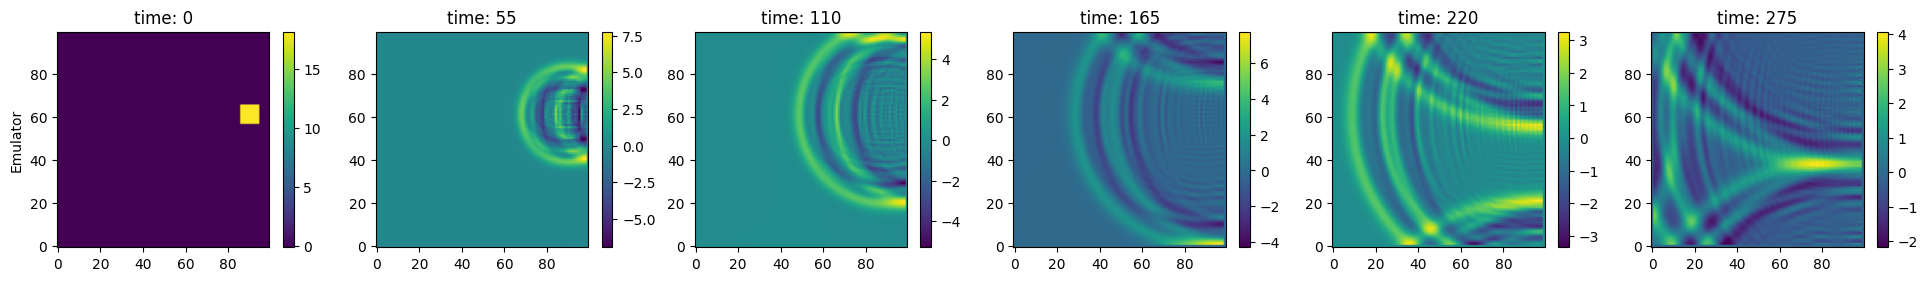

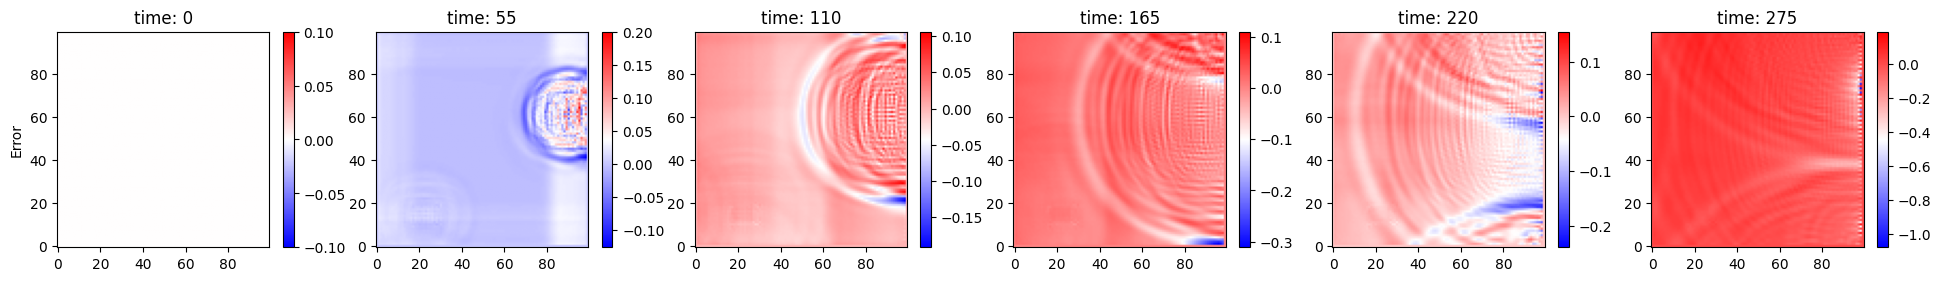

In [39]:
gt_sims = np.moveaxis(jnp.array(ocean_ds.X_input), 1, -1)
print(gt_sims.shape)
# plot the simulation
num_subplot = 6
jump = 55
plt.figure(figsize=(num_subplot*4, 2.8))
for i in range(num_subplot):
    j = i * jump
    plt.subplot(1, num_subplot, i+1)
    plt.imshow(gt_sims[j, :, :, 0], origin="lower", aspect="auto")
    plt.title(f"time: {j}")
    plt.colorbar()
    if i == 0:
        plt.ylabel("Simulator")
plt.figure(figsize=(num_subplot*4, 2.8))
for i in range(num_subplot):
    j = i * jump
    plt.subplot(1, num_subplot, i+1)
    plt.imshow(emulator_sims[j, :, :, 0], origin="lower", aspect="auto")
    plt.title(f"time: {j}")
    plt.colorbar()
    if i == 0:
        plt.ylabel("Emulator")
plt.figure(figsize=(num_subplot*4, 2.8))
for i in range(num_subplot):
    j = i * jump
    plt.subplot(1, num_subplot, i+1)
    plt.imshow((gt_sims - emulator_sims)[j, :, :, 0], origin="lower", aspect="auto", cmap="bwr")
    plt.title(f"time: {j}")
    plt.colorbar()
    if i == 0:
        plt.ylabel("Error")
# fig, axs = plt.subplots(1, 5, figsize=(20, 2))
# for i in range(5):
#     j = i*70
#     axs[i].imshow(Xs[j, 0, :, :], origin="lower")
#     axs[i].axis("off")


## Observation 

In [40]:
Nx = ssh.shape[2]
Ny = ssh.shape[3]
Nt_steps = time_steps
t0 = 0
Nt_warmup = 10
t_warmup = Nt_warmup * DT
tmax = (Nt_steps - 1) * DT
print('Nx:', Nx)
print('Ny:', Ny)
print('t0:', t0)
print('t_warmup:', t_warmup)
print('tmax:', tmax)

Nx: 100
Ny: 100
t0: 0
t_warmup: 3000
tmax: 89700


In [41]:
# generate observations
print('generating observations.')
obs_frequency = 10 # every 10th time step
Nt_obs = int((tmax - t_warmup) / (obs_frequency * DT)) + 1
print(Nt_obs)
# obs_idx_t = [obs_frequency * i for i in range(Nt_obs)]  # oib
# print("len of obs_idx_t", len(obs_idx_t))
# print('obs_idx_t:', obs_idx_t)

generating observations.
29


In [42]:
idx_t = [i for i in range(Nt_steps)]
idx_t_warmup = [i for i in range(Nt_warmup)]
idx_t_after_warmup = [i for i in range(Nt_warmup, Nt_steps)]
idx_t_obs = [i for i in range(Nt_warmup, Nt_steps, obs_frequency)]
print('idx_t:', idx_t)
print('len(idx_t):', len(idx_t))
print('idx_t_init:', idx_t_warmup)
print('len(idx_t_init):', len(idx_t_warmup))
print('idx_t_after_warmup:', idx_t_after_warmup)
print('len(idx_t_after_warmup):', len(idx_t_after_warmup))
print('idx_t_obs:', idx_t_obs)
print('len(idx_t_obs):', len(idx_t_obs))
Nt_after_warmup = len(idx_t_after_warmup)
print('Nt_after_warmup:', Nt_after_warmup)


idx_t: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [43]:
t = [t0 + i * DT for i in range(Nt_steps)]
t_warmup = [t0 + i * DT for i in range(Nt_warmup)]
t_after_warmup = [t_warmup[-1] + i * DT for i in range(1, Nt_steps - Nt_warmup + 1)]
t_obs = t_after_warmup[::obs_frequency]

print('t:', t)
print('len(t):', len(t))
print('t_warmup:', t_warmup)
print('len(t_warmup))', len(t_warmup))
print('t_after_warmup:', t_after_warmup)
print('len(t_after_warmup))', len(t_after_warmup))
print('t_obs:', t_obs)
print('len(t_obs))', len(t_obs))

t: [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600, 3900, 4200, 4500, 4800, 5100, 5400, 5700, 6000, 6300, 6600, 6900, 7200, 7500, 7800, 8100, 8400, 8700, 9000, 9300, 9600, 9900, 10200, 10500, 10800, 11100, 11400, 11700, 12000, 12300, 12600, 12900, 13200, 13500, 13800, 14100, 14400, 14700, 15000, 15300, 15600, 15900, 16200, 16500, 16800, 17100, 17400, 17700, 18000, 18300, 18600, 18900, 19200, 19500, 19800, 20100, 20400, 20700, 21000, 21300, 21600, 21900, 22200, 22500, 22800, 23100, 23400, 23700, 24000, 24300, 24600, 24900, 25200, 25500, 25800, 26100, 26400, 26700, 27000, 27300, 27600, 27900, 28200, 28500, 28800, 29100, 29400, 29700, 30000, 30300, 30600, 30900, 31200, 31500, 31800, 32100, 32400, 32700, 33000, 33300, 33600, 33900, 34200, 34500, 34800, 35100, 35400, 35700, 36000, 36300, 36600, 36900, 37200, 37500, 37800, 38100, 38400, 38700, 39000, 39300, 39600, 39900, 40200, 40500, 40800, 41100, 41400, 41700, 42000, 42300, 42600, 42900, 43200, 43500, 43800, 44100, 

## Temporal observation

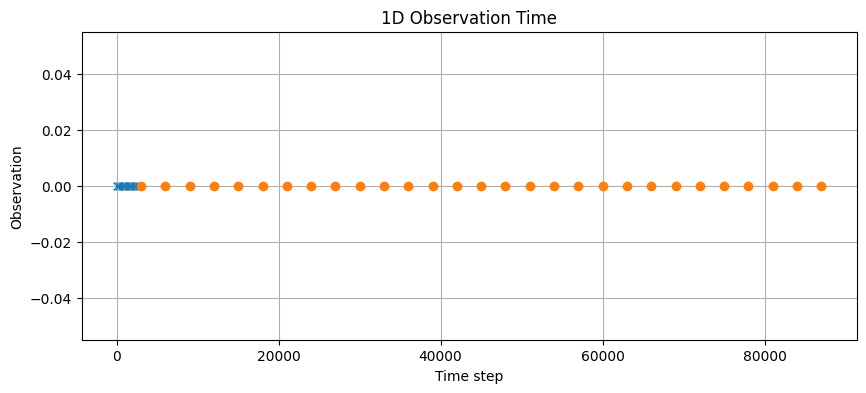

In [44]:
plt.figure(figsize=(10, 4))
plt.plot(t_warmup, np.zeros_like(t_warmup), 'x')
plt.plot(t_obs, np.zeros_like(t_obs), 'o')
plt.xlabel('Time step')
plt.ylabel('Observation')
plt.title('1D Observation Time')
plt.grid(True)
plt.show()

In [45]:
gt_sims.shape

(300, 100, 100, 3)

## Generating the masks

In [49]:
def create_mask(ratio_obs, Nx, Ny, Nt_obs, key):
    mask = jnp.zeros((Nt_obs, Nx, Ny, 3))
    for i in range(Nt_obs):
        key, subkey = jax.random.split(key)
        mask = mask.at[i, :, :, 0].set(jax.random.choice(subkey, jnp.array([0, 1]), shape=(Nx, Ny), p=jnp.array([1-ratio_obs, ratio_obs])))
        key, subkey = jax.random.split(key)
        mask = mask.at[i, :, :, 1].set(jax.random.choice(subkey, jnp.array([0, 1]), shape=(Nx, Ny), p=jnp.array([1-ratio_obs, ratio_obs])))
        key, subkey = jax.random.split(key)
        mask = mask.at[i, :, :, 2].set(jax.random.choice(subkey, jnp.array([0, 1]), shape=(Nx, Ny), p=jnp.array([1-ratio_obs, ratio_obs])))
    return mask

ratio_obs = 0.5
key = jax.random.PRNGKey(0)
mask = create_mask(ratio_obs, Nx, Ny, Nt_obs, key)
print(mask.shape)

(29, 100, 100, 3)


In [50]:
type(mask)

jaxlib.xla_extension.ArrayImpl

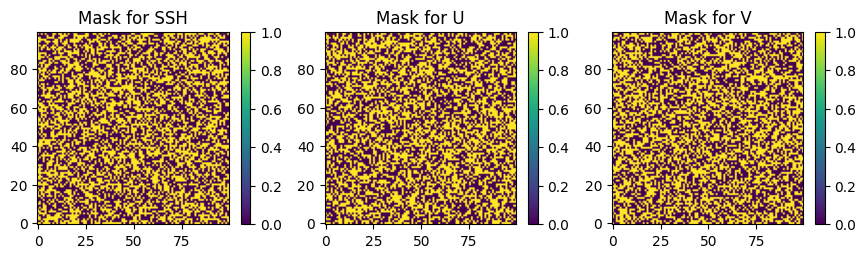

In [51]:

# plot the mask
plt.figure(figsize=(10.5, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(mask[0, :, :, 0], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Mask for SSH')
plt.subplot(1, 3, 2)
plt.imshow(mask[0, :, :, 1], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Mask for U')
plt.subplot(1, 3, 3)
plt.imshow(mask[0, :, :, 2], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Mask for V')
plt.show()

## Apply the mask to the input data to create the pseduo observation

In [57]:
# create a jax x_obs based on numpy gt_sims
x_obs_jax = gt_sims[idx_t_obs, :, :, :]
print(x_obs_jax.shape)
print(type(x_obs_jax))

(29, 100, 100, 3)
<class 'jaxlib.xla_extension.ArrayImpl'>


In [58]:
mask.shape

(29, 100, 100, 3)

In [59]:
# apply the mask to the input data to create the observation
def apply_mask(data, mask):
    data_obs = data * mask
    return data_obs

# create the observation
y_obs_jax = apply_mask(x_obs_jax, mask)

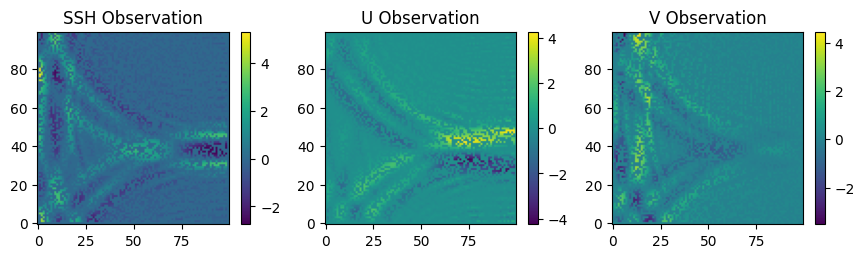

In [60]:
# plot the y_obs_jax
plt.figure(figsize=(10.5, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(y_obs_jax[-1, :, :, 0], origin='lower', aspect='auto')
plt.colorbar()
plt.title('SSH Observation')
plt.subplot(1, 3, 2)
plt.imshow(y_obs_jax[-1, :, :, 1], origin='lower', aspect='auto')
plt.colorbar()
plt.title('U Observation')
plt.subplot(1, 3, 3)
plt.imshow(y_obs_jax[-1, :, :, 2], origin='lower', aspect='auto')
plt.colorbar()
plt.title('V Observation')
plt.show()



(1, 100, 100, 3)
<class 'jaxlib.xla_extension.ArrayImpl'>


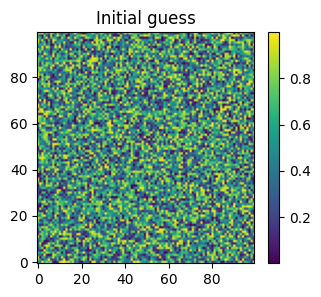

In [61]:
# create the initial guess 
key = jax.random.PRNGKey(1)
x0_jax = jax.random.uniform(key, (1, Nx, Ny, 3))
print(x0_jax.shape)
print(type(x0_jax))
# plot the initial guess
plt.figure(figsize=((3.5, 3)))
plt.subplot(1, 1, 1)
plt.imshow(x0_jax[0, :, :, 0], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Initial guess')
plt.show()

# Coding 4DVar algorithm

(29, 100, 100, 3)


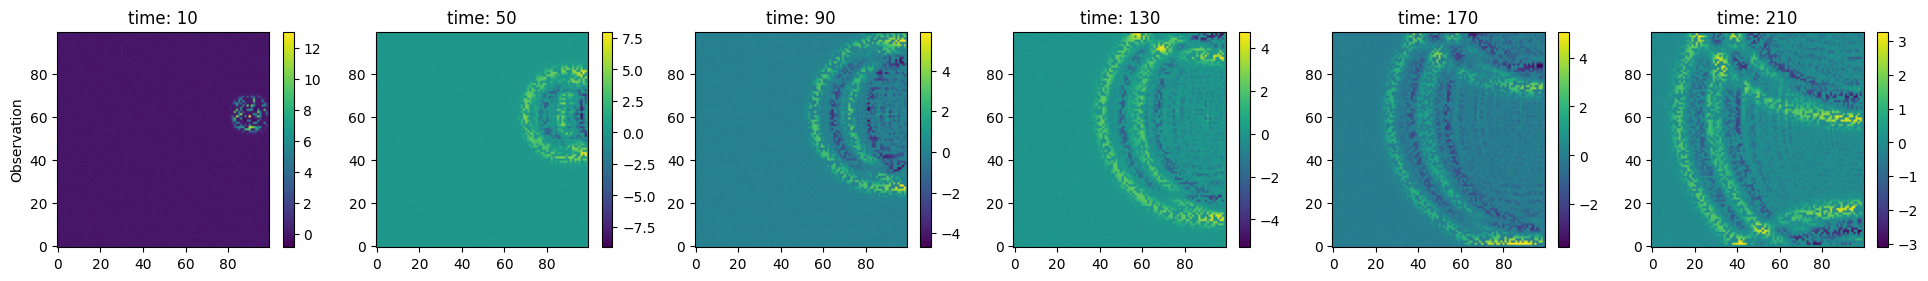

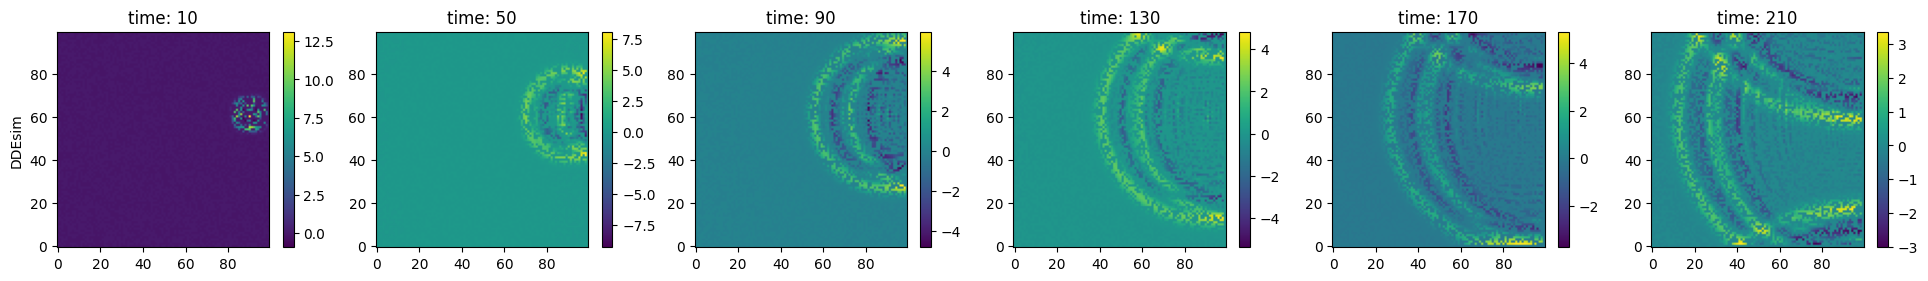

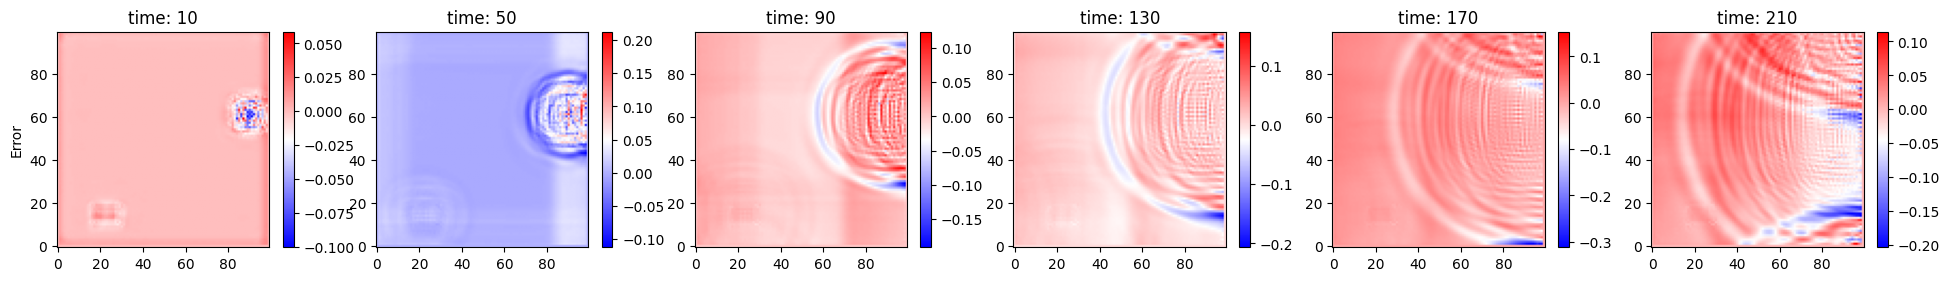

In [64]:
simulations = run_simulation(x0, emulator, H0, mask0, idx_t_obs)
print(simulations.shape)

num_subplot = 6
jump = 4
plt.figure(figsize=(num_subplot*4, 2.8))
for i in range(num_subplot):
    j = i * jump
    plt.subplot(1, num_subplot, i+1)
    plt.imshow(apply_mask(x_obs_jax, mask)[j, :, :, 0], origin="lower", aspect="auto")
    plt.title(f"time: {(j+1) * obs_frequency}")
    plt.colorbar()
    if i == 0:
        plt.ylabel("Observation")
plt.figure(figsize=(num_subplot*4, 2.8))
for i in range(num_subplot):
    j = i * jump
    plt.subplot(1, num_subplot, i+1)
    plt.imshow(apply_mask(simulations, mask)[j, :, :, 0], origin="lower", aspect="auto")
    plt.title(f"time: {(j+1) * obs_frequency}")
    plt.colorbar()
    if i == 0:
        plt.ylabel("DDEsim")
plt.figure(figsize=(num_subplot*4, 2.8))
for i in range(num_subplot):
    j = i * jump
    plt.subplot(1, num_subplot, i+1)
    plt.imshow((x_obs_jax - simulations)[j, :, :, 0], origin="lower", aspect="auto", cmap="bwr")
    plt.title(f"time: {(j+1) * obs_frequency}")
    plt.colorbar()
    if i == 0:
        plt.ylabel("Error")
plt.show()

In [65]:
# @functools.partial(jax.vmap, in_axes=(None, 0))
# define the cost function using @functools where we keep the mask in constant, x and y_obs are the variables
import functools
from jax import jit

def cost_function(x0, y_obs, mask, emulator, H0, mask0, idx_t_obs):
    x = run_simulation(x0, emulator, H0, mask0, idx_t_obs)
    x_obs = apply_mask(x, mask)
    # compute the rmse
    rmse = jnp.sqrt(jnp.mean((x_obs - y_obs)**2))
    return rmse

In [66]:
import optax

def run_4DVar(x0, mask, y_obs, emulator, H0, mask_domain_0, idx_t_obs, N_iter, lr=0.1):
    optimizer = optax.adam(lr)
    optimizer_state = optimizer.init(x0)
    for i in range(N_iter):
        print("iter: ", i)
        # # convert x0 from jax array to pytorch tensor
        # x0_numpy = onp.array(x0)
        # x0_torch = torch.from_numpy(x0_numpy).to(torch.float32)
        # x = run_simulation_jax(x0, emulator, params0, H0, mask0, idx_t_obs) # run the simulation using the emulator written in Pytorch
        # x_jax = jnp.array(simulations.detach().cpu().numpy()) # convert the simulation to jax array
        grads = jax.grad(cost_function)(x0, y_obs, mask, emulator, H0, mask_domain_0, idx_t_obs)
        print("loss: ", cost_function(x0, y_obs, mask, emulator, H0, mask_domain_0, idx_t_obs))
        updates, optimizer_state = optimizer.update(grads, optimizer_state)
        x0 = optax.apply_updates(x0, updates)
    return x0

In [70]:
type(y_obs_jax)
print(y_obs_jax.shape)

(29, 100, 100, 3)


In [ ]:
final_x0 = run_4DVar(x0, mask, y_obs_jax, emulator, H0, mask0, idx_t_obs, 100, 0.1)

iter:  0
loss:  0.17925917
iter:  1
loss:  37.88889
iter:  2
